# **Ejercicio 2: Análisis de condiciones de vivienda en México usando datos del INEGI**

Descripción:
Usar datos de la Encuesta Nacional de Ingresos y Gastos de los Hogares (ENIGH) del INEGI
para analizar las condiciones de vivienda (material del techo, acceso al agua, número de
cuartos, etc.) y predecir si una vivienda se encuentra en una situación de carencia
habitacional.

# ***1. Carga y exploración general de los datos***

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV

In [11]:
# Cargar los datos
data = pd.read_csv('viviendas.csv')

# Exploración inicial
print("Dimensiones del dataset:", data.shape)
print("\nPrimeras filas:")
print(data.head())
print("\nResumen estadístico:")
print(data.describe())
print("\nTipos de datos:")
print(data.dtypes)
print("\nValores nulos por columna:")
print(data.isnull().sum())

/tmp/ipython-input-11-119014673.py:2: DtypeWarning: Columns (4,24) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('viviendas.csv')


Dimensiones del dataset: (88823, 64)

Primeras filas:
    folioviv tipo_viv  mat_pared  mat_techos mat_pisos antiguedad antigua_ne  \
0  100005002        1          8          10         3         30              
1  100005003        1          8          10         3         15              
2  100005004        1          8          10         3         25              
3  100012002        1          8          10         3         50              
4  100012004        1          8          10         3         45              

   cocina cocina_dor  cuart_dorm  ...  tot_hom  tot_muj tot_hog  ubica_geo  \
0       1          2           2  ...        0        3       1       1001   
1       1          2           3  ...        1        1       1       1001   
2       1          2           3  ...        2        1       1       1001   
3       1          2           4  ...        3        2       2       1001   
4       1          2           3  ...        2        2       1       1001 

# ***2. Limpieza básica***

In [12]:
# Eliminar columnas con muchos valores nulos o no relevantes
columnas_a_eliminar = ['antigua_ne', 'renta', 'pago_viv', 'pago_mesp', 'num_dueno2', 'hog_dueno2']
data = data.drop(columns=columnas_a_eliminar)

# Rellenar valores nulos en variables numéricas con la mediana
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns
for col in numeric_cols:
    data[col].fillna(data[col].median(), inplace=True)

# Eliminar filas duplicadas
data = data.drop_duplicates()

# Convertir columnas categóricas a tipo 'category'
categorical_cols = ['tipo_viv', 'mat_pared', 'mat_techos', 'mat_pisos', 'disp_agua', 'dotac_agua', 'excusado']
for col in categorical_cols:
    data[col] = data[col].astype('category')

print("\nDatos después de limpieza:")
print(data.info())

/tmp/ipython-input-12-833154158.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].median(), inplace=True)



Datos después de limpieza:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88823 entries, 0 to 88822
Data columns (total 58 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   folioviv     88823 non-null  int64   
 1   tipo_viv     88823 non-null  category
 2   mat_pared    88823 non-null  category
 3   mat_techos   88823 non-null  category
 4   mat_pisos    88823 non-null  category
 5   antiguedad   88823 non-null  object  
 6   cocina       88823 non-null  int64   
 7   cocina_dor   88823 non-null  object  
 8   cuart_dorm   88823 non-null  int64   
 9   num_cuarto   88823 non-null  int64   
 10  disp_agua    88823 non-null  category
 11  dotac_agua   88823 non-null  category
 12  excusado     88823 non-null  category
 13  uso_compar   88823 non-null  object  
 14  sanit_agua   88823 non-null  object  
 15  biodigest    88823 non-null  object  
 16  bano_comp    88823 non-null  object  
 17  bano_excus   88823 non-null  object  
 18

# ***3. Análisis exploratorio y visualización inicial***

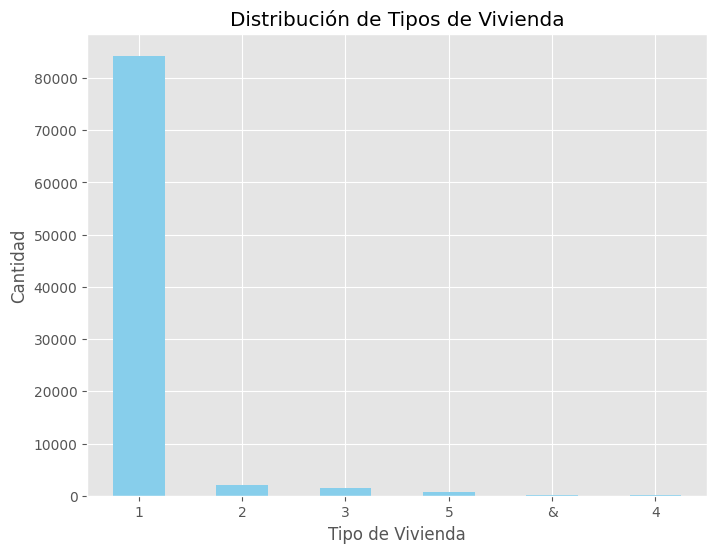

In [18]:
# Configuración de estilo para gráficos
plt.style.use('ggplot')

# 1. Distribución de tipos de vivienda
plt.figure(figsize=(8, 6))
data['tipo_viv'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribución de Tipos de Vivienda')
plt.xlabel('Tipo de Vivienda')
plt.ylabel('Cantidad')
plt.xticks(rotation=0)
plt.show()

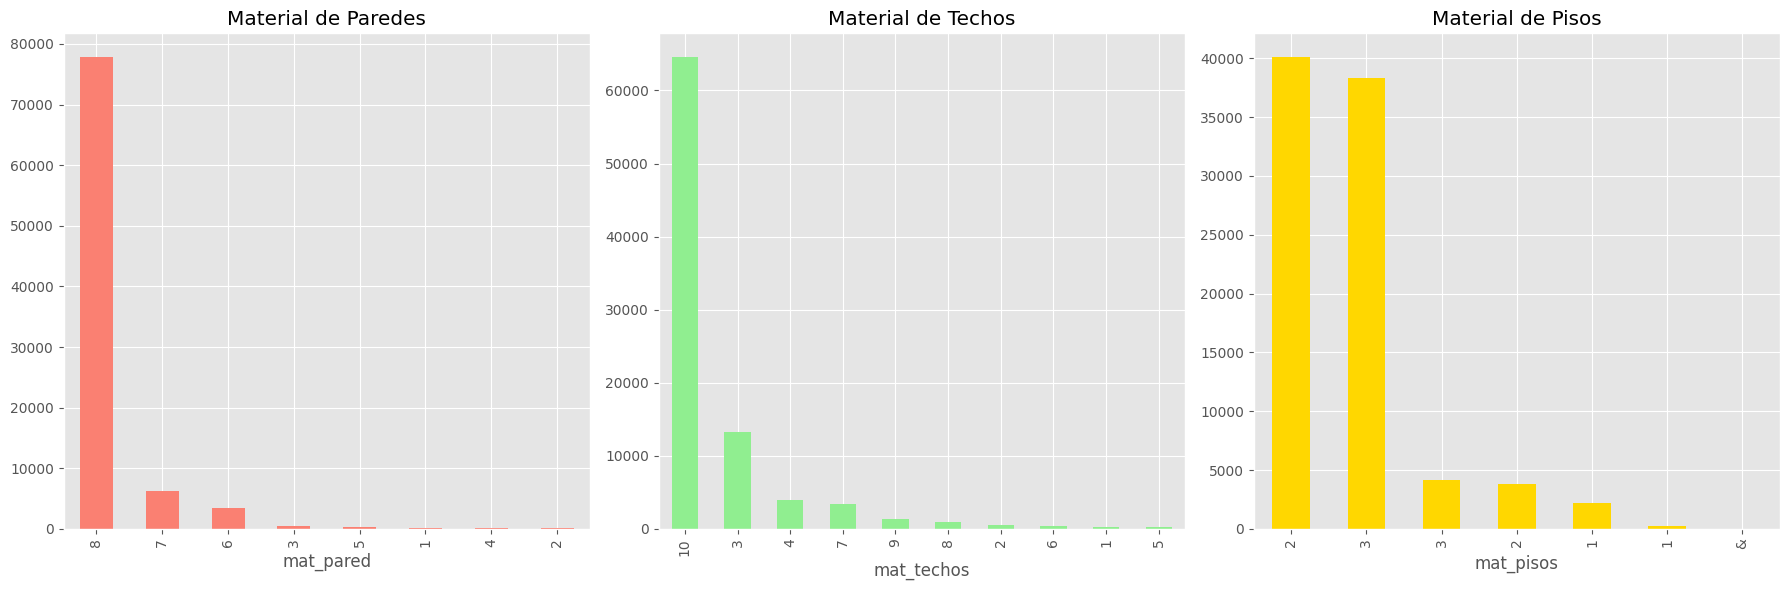

In [19]:
# 2. Materiales de construcción
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

data['mat_pared'].value_counts().plot(kind='bar', ax=axes[0], color='salmon')
axes[0].set_title('Material de Paredes')

data['mat_techos'].value_counts().plot(kind='bar', ax=axes[1], color='lightgreen')
axes[1].set_title('Material de Techos')

data['mat_pisos'].value_counts().plot(kind='bar', ax=axes[2], color='gold')
axes[2].set_title('Material de Pisos')

plt.tight_layout()
plt.show()

/tmp/ipython-input-20-2774842057.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=servicio, data=data, palette='viridis')


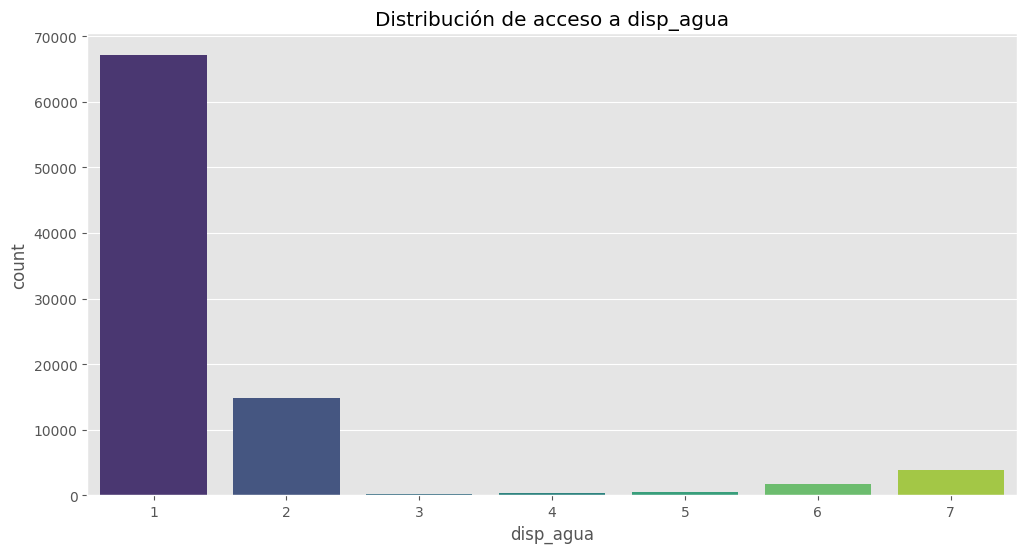

/tmp/ipython-input-20-2774842057.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=servicio, data=data, palette='viridis')


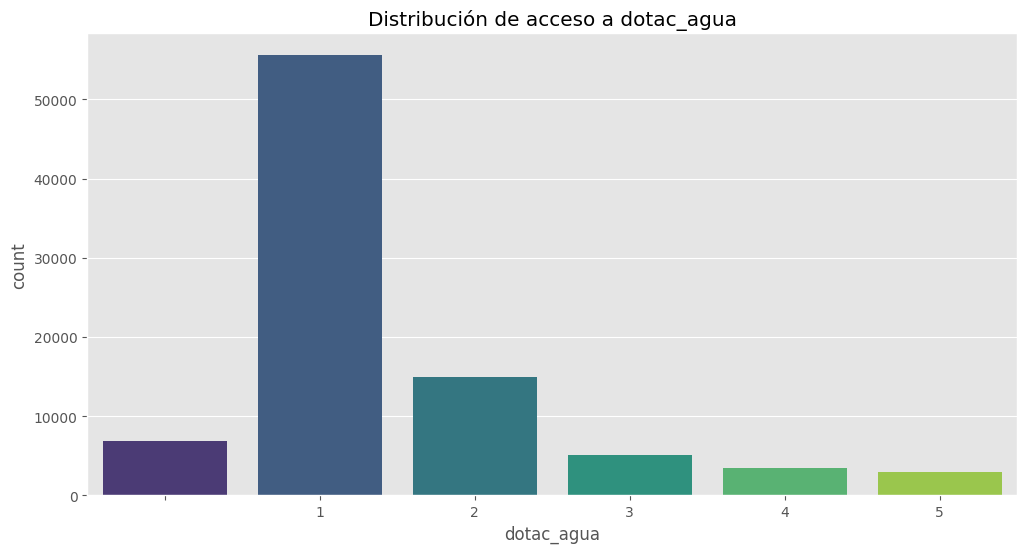

/tmp/ipython-input-20-2774842057.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=servicio, data=data, palette='viridis')


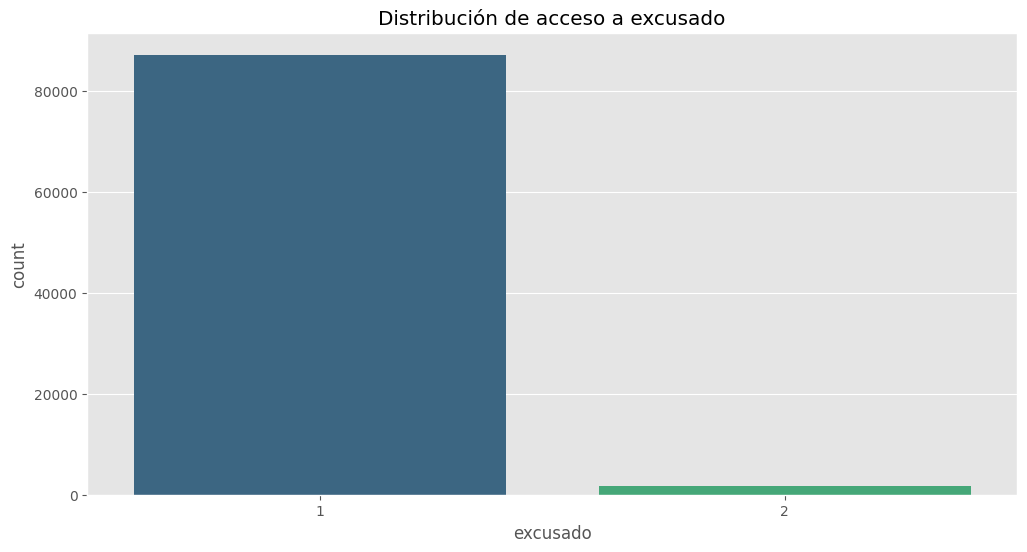

/tmp/ipython-input-20-2774842057.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=servicio, data=data, palette='viridis')


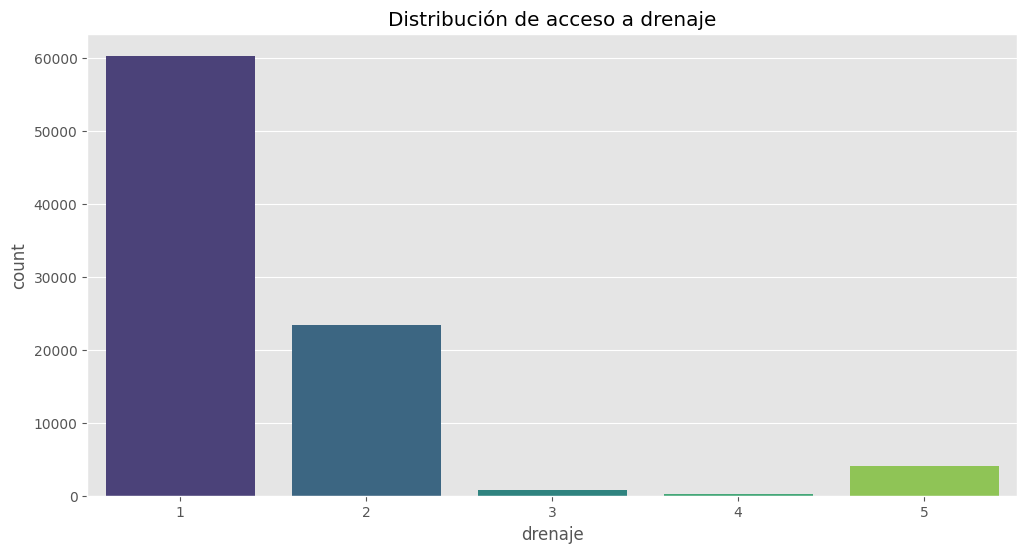

/tmp/ipython-input-20-2774842057.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=servicio, data=data, palette='viridis')


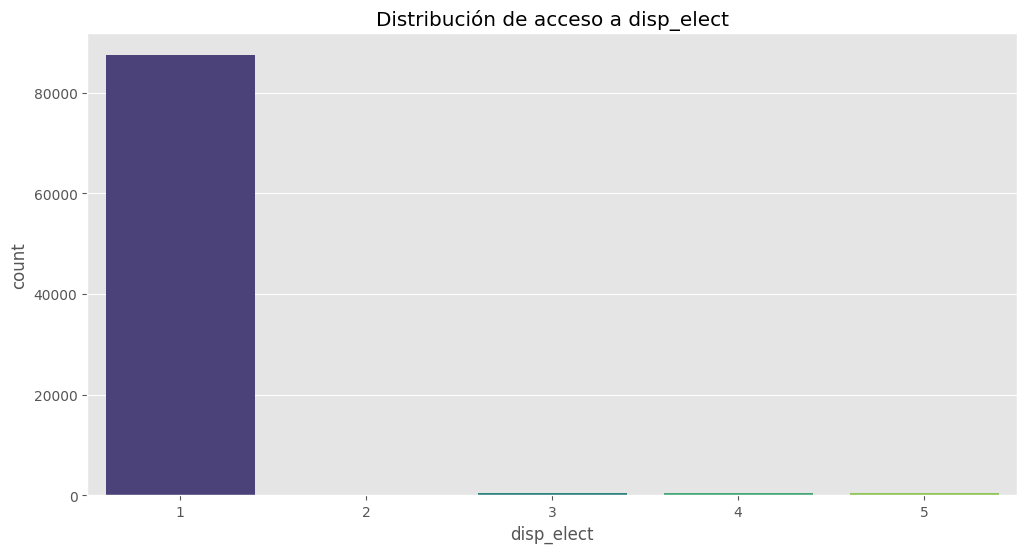

In [20]:
# 3. Acceso a servicios básicos
plt.figure(figsize=(12, 6))
servicios = ['disp_agua', 'dotac_agua', 'excusado', 'drenaje', 'disp_elect']
for servicio in servicios:
    sns.countplot(x=servicio, data=data, palette='viridis')
    plt.title(f'Distribución de acceso a {servicio}')
    plt.show()

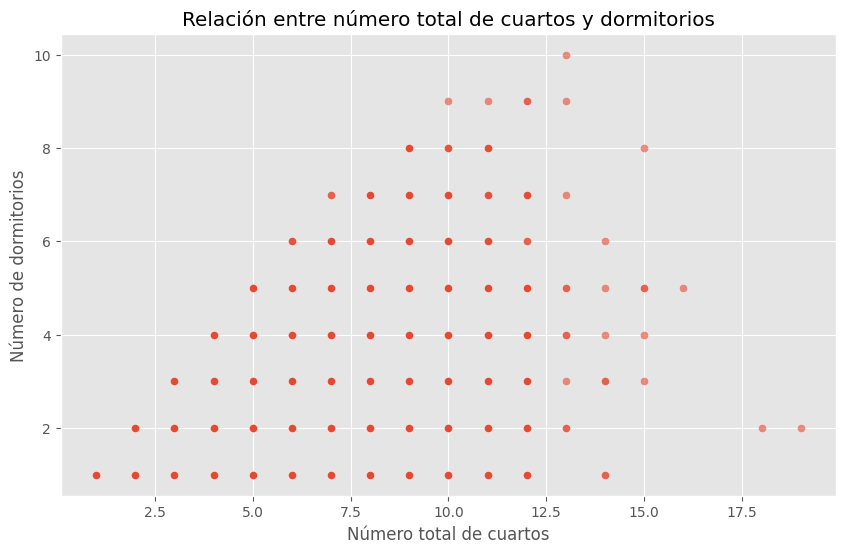

In [21]:
# 4. Relación entre número de cuartos y dormitorios
plt.figure(figsize=(10, 6))
sns.scatterplot(x='num_cuarto', y='cuart_dorm', data=data, alpha=0.6)
plt.title('Relación entre número total de cuartos y dormitorios')
plt.xlabel('Número total de cuartos')
plt.ylabel('Número de dormitorios')
plt.show()

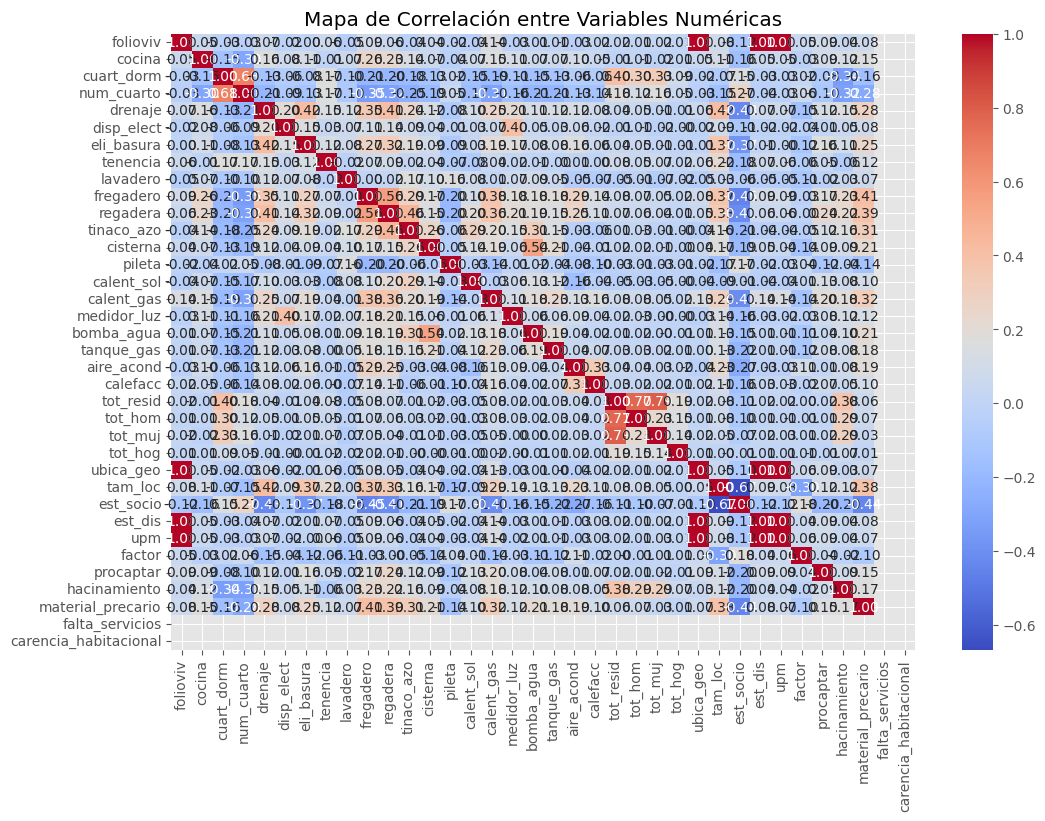

In [22]:
# 5. Correlación entre variables numéricas
plt.figure(figsize=(12, 8))
numeric_data = data.select_dtypes(include=['int64', 'float64'])
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Mapa de Correlación entre Variables Numéricas')
plt.show()

# ***4. Preprocesamiento de datos***

In [27]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Definición de carencia habitacional (variable objetivo)
data['hacinamiento'] = np.where(data['tot_resid'] / data['cuart_dorm'] > 2.5, 1, 0)
data['material_precario'] = np.where((data['mat_pared'].isin([1, 2, 3])) |
                                    (data['mat_techos'].isin([1, 2, 3])) |
                                    (data['mat_pisos'].isin([1, 2])), 1, 0)
data['falta_servicios'] = np.where((data['disp_agua'] != 1) |
                                  (data['dotac_agua'] != 1) |
                                  (data['excusado'] != 1) |
                                  (data['drenaje'] != 1) |
                                  (data['disp_elect'] != 1), 1, 0)

data['carencia_habitacional'] = np.where(
    (data['hacinamiento'] + data['material_precario'] + data['falta_servicios']) >= 2, 1, 0)

# Selección de características
features = ['tipo_viv', 'mat_pared', 'mat_techos', 'mat_pisos', 'antiguedad',
            'num_cuarto', 'cuart_dorm', 'disp_agua', 'dotac_agua', 'excusado',
            'drenaje', 'disp_elect', 'tot_resid', 'tot_hom', 'tot_muj', 'tam_loc']
X = data[features]
y = data['carencia_habitacional']

# Codificación de variables categóricas
X = pd.get_dummies(X, columns=['tipo_viv', 'mat_pared', 'mat_techos', 'mat_pisos',
                              'disp_agua', 'dotac_agua', 'excusado', 'drenaje',
                              'disp_elect', 'tam_loc'], drop_first=True)

# División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)


print("\n=== Preprocesamiento Completado ===")
print(f"Dimensiones X_train: {X_train.shape}")
print(f"Dimensiones X_test: {X_test.shape}")
print("Distribución de clases en y_train:", pd.Series(y_train).value_counts(normalize=True))


=== Preprocesamiento Completado ===
Dimensiones X_train: (62176, 56)
Dimensiones X_test: (26647, 56)
Distribución de clases en y_train: carencia_habitacional
1    0.563626
0    0.436374
Name: proportion, dtype: float64


# ***6. Evaluación de Modelos***

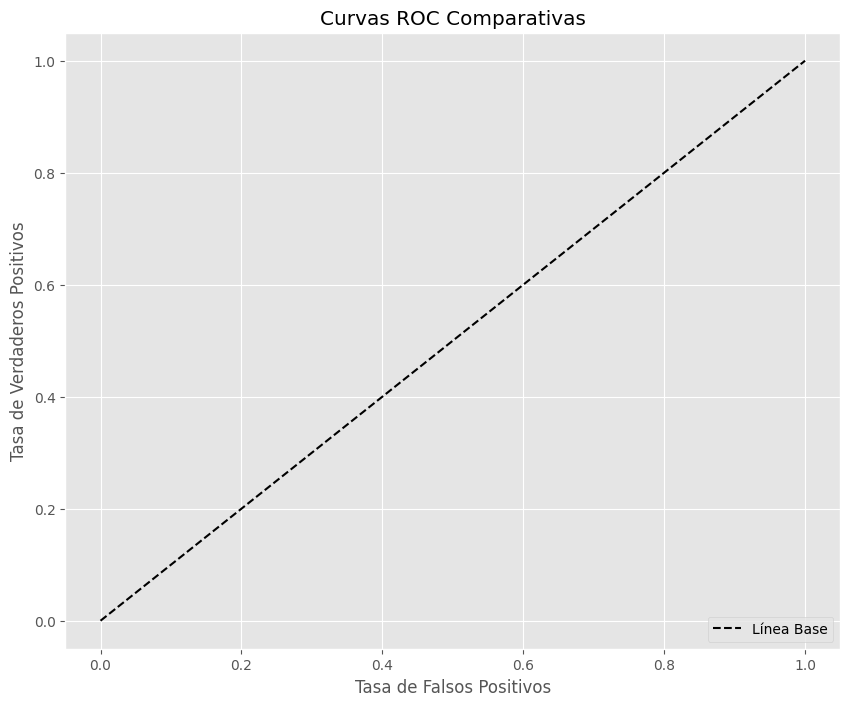

In [30]:
from sklearn.metrics import (classification_report, confusion_matrix,
                            accuracy_score, roc_auc_score, roc_curve)

def evaluate_model(model, X_test, y_test, model_name):
    # Predicciones
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Métricas
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    report = classification_report(y_test, y_pred)
    matrix = confusion_matrix(y_test, y_pred)

    # Resultados
    print(f"\n=== Evaluación de {model_name} ===")
    print(f"Exactitud (Accuracy): {accuracy:.4f}")
    print(f"AUC-ROC: {roc_auc:.4f}")
    print("\nReporte de Clasificación:")
    print(report)
    print("\nMatriz de Confusión:")
    print(matrix)

    # Curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'classification_report': report,
        'confusion_matrix': matrix
    }

# Evaluar todos los modelos
plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--', label='Línea Base')

evaluation_results = {}
for name, result in results.items():
    eval_result = evaluate_model(result['best_model'], X_test, y_test, name)
    evaluation_results[name] = eval_result

plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC Comparativas')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()